# PyTorch - homework TF 3: generative convolutional models

-- Prof. Dorien Herremans

Please run the whole notebook with your code and submit the `.ipynb` file on eDimension that includes your answers [so after you run it]. 

In [1]:
from termcolor import colored

student_number="1003056"
student_name="Ivan Christian"

print(colored("Homework by "  + student_name + ', number: ' + student_number,'red'))

Homework by Ivan Christian, number: 1003056


 ## Question 1 -- Generate images based on a condition

Task: develop a generative model (either cGAN or cVaE) that can generate images based on a class label (bee or ant). 

a) Training dataset: small subset of ImageNet: https://download.pytorch.org/tutorial/hymenoptera_data.zip. You can leverage the ImageFolder class as demonstrated here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html. Since we don't need a test set for generation, you can combine both test and training datasets. 

To handle using custom datasets, torchvision provides a datasets.ImageFolder class. ImageFolder expects data to be stored in the following way:

*   root/class_x/xxy.png
*   root/class_x/xxz.jpg
*   root/class_y/123.jpeg
*   root/class_y/nsdf3.png
*   root/class_y/asd932_.jpg

b) Normalize the training data and perform data augmentation. For those interested in knowing how to calculate the means for normalizing, please refer to this excellent resource here: https://github.com/bentrevett/pytorch-image-classification/blob/master/5%20-%20ResNet.ipynb and the previously mentioned link. 



In [2]:
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import os
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
'''
Data Augmentation 
'''
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# load images and normalize + augment data
data_dir = 'data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x])for x in ['train', 'val']} #normalisation and data augmentation
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


c) Show a few images from the dataset so we understand what we are working with. 



In [5]:
# explore the data
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

bees tensor(1)
ants tensor(0)
ants tensor(0)
ants tensor(0)


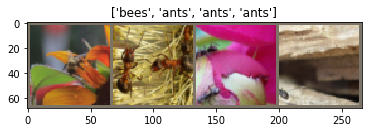

In [6]:
inputs, classes = next(iter(dataloaders['train']))
out = make_grid(inputs)
class_names = image_datasets['train'].classes

for x in classes:
    print(class_names[x], x)
imshow(out, title=[class_names[x] for x in classes])


d) Implement a conditional generative model. Use at least one convolutional layer in your generative model and define a loss function that makes sense for this problem. 


In [7]:
# your model here

'''
Discriminator
'''
class Discriminator (nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(20, 20)
        
        self.conv1 = nn.Conv2d(3, 64, 5, 1, 2)
        self.maxpool1 = nn.MaxPool2d(5)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(5)
        self.conv2 = nn.Conv2d(64, 32, 5, 1, 2)
        self.bn2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(5)
        self.fc1 = nn.Linear(32*64*64+20, 32)
        self.fc2 = nn.Linear(32, 1)
        
        self.fc3 = nn.Linear (4, 20)
        
    def forward(self, x, labels):
        batch_size = x.size(0)
        x = x.view(batch_size, 3, 64, 64)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x,0.2,inplace=True)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x,0.2,inplace=True)
        
        x = x.view(batch_size, 32*64*64) #Flatten
        
        #float? its int64
#         y_ = self.fc3(labels)
        y_ = self.label_emb(labels)
#         y_ = F.relu(y_)
        y_ = F.leaky_relu(y_,0.2,inplace=True)
        
        x = torch.cat([x,y_],1)
        
        x = self.fc1(x)
        x = F.leaky_relu(x,0.2,inplace=True)
        
        x = self.fc2(x)
        
        return torch.sigmoid(x).squeeze()
# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         # use an embedding layer for the layer
#         self.label_emb = nn.Embedding(20, 20)
        
#         self.model = nn.Sequential(
#             nn.Linear(3*32*32+20, 1024),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(1024, 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Dropout(0.3),
#             nn.Linear(256, 1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, x, labels):
#         x = x.view(x.size(0), 3*32*32)
#         c = self.label_emb(labels)
#         # concatenates x and c, so the condition is given as input to the model appended to the image x
#         x = torch.cat([x, c], 1)
#         out = self.model(x)
#         return out.squeeze()

In [8]:
'''
Generator
'''

class Generator (nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.z_dim = 20
        self.label_emb = nn.Embedding(20, 20)
        
        self.fc1 = nn.Linear(self.z_dim + 20, 32 *64 * 64)
        
        self.bn2 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(32 , 64, 5, 1, 2)
        self.maxpool1 = nn.MaxPool2d(3)
        self.bn1 = nn.BatchNorm2d(3)
        self.deconv1 = nn.ConvTranspose2d(64, 3, 5, 1, 2)
        self.maxpool2 = nn.MaxPool2d(3)
    def forward (self, x, labels):
        batch_size = x.size(0)
        
        
#         y_ = self.fc2(labels)
        y_ = self.label_emb(labels)
#         y_ = F.relu(y_)
        y_ = F.leaky_relu(y_,0.2,inplace=True)
        
        x = torch.cat([x,y_], 1)
        
        x = self.fc1(x)
        x = x.view(batch_size, 32, 64,64)
        
        
        x = F.leaky_relu(x,0.2,inplace=True)
        x = self.deconv2(x)
#         x = self.maxpool2(x)
        x = self.bn2(x)
        
        
        x = F.leaky_relu(x,0.2,inplace=True)
        x = self.deconv1(x)
#         x = self.maxpool1(x)
        x = self.bn1(x)
        
        x = torch.sigmoid(x)
        
        return x


# class Generator(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         self.label_emb = nn.Embedding(20, 20)
        
#         self.model = nn.Sequential(
#             nn.Linear(40, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(256, 512),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(512, 1024),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(1024, 3*32*32),
#             nn.Tanh()
#         )
    
#     def forward(self, z, labels):
#         z = z.view(z.size(0), 20)
#         c = self.label_emb(labels)
#         x = torch.cat([z, c], 1) # concatenates z and c, so the condition is given as input to the model appended to z
#         out = self.model(x)

#         return out.view(x.size(0), 3,32, 32)

In [9]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-3)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)


e) Train the network on cuda (I recommend to be clever and use a technique such as mini batches to train effectively, optional though). Show how the loss of the model evolves during training. 

f) Generate 4 images of each class after a number of epochs so we can see the generation quality improving during training.





In [10]:
def discriminator_train_step(batch_size, discriminator,generator, d_optimizer, criterion, real_images, labels):
    discriminator.train()
    generator.train()
    d_optimizer.zero_grad()    
    real_validity = discriminator(real_images,labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    z = Variable(torch.randn(batch_size, 20)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 2, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    # optimize the sum of both losses
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data

In [11]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    generator.train() # training phase
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 20)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 1, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data

Starting epoch 1
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 0, 0, 1], device='cuda:0')
1 : bees
0 : ants


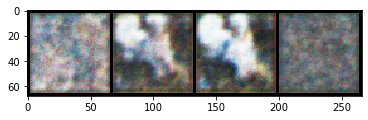

Starting epoch 2
g_loss: 47.75755310058594, d_loss: 0.033015016466379166
tensor([0, 1, 0, 0], device='cuda:0')
1 : bees
0 : ants


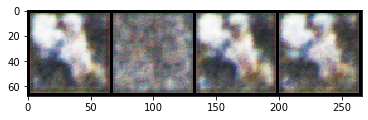

Starting epoch 3
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 1, 0, 1], device='cuda:0')
1 : bees
0 : ants


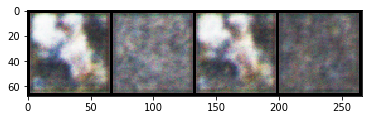

Starting epoch 4
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 0, 0, 1], device='cuda:0')
1 : bees
0 : ants


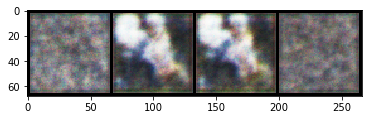

Starting epoch 5
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 0, 0, 1], device='cuda:0')
1 : bees
0 : ants


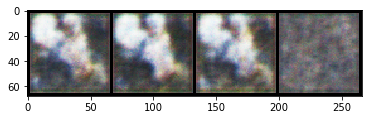

Starting epoch 6
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 0, 0, 0], device='cuda:0')
1 : bees
0 : ants


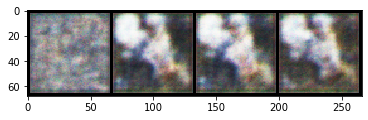

Starting epoch 7
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 1, 1, 1], device='cuda:0')
1 : bees
0 : ants


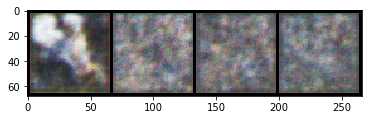

Starting epoch 8
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 0, 0, 0], device='cuda:0')
1 : bees
0 : ants


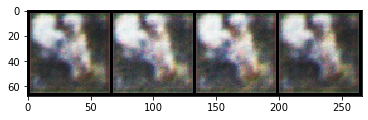

Starting epoch 9
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 0, 0, 1], device='cuda:0')
1 : bees
0 : ants


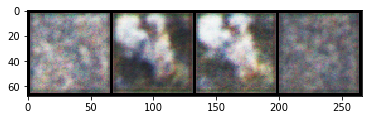

Starting epoch 10
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 1, 1, 0], device='cuda:0')
1 : bees
0 : ants


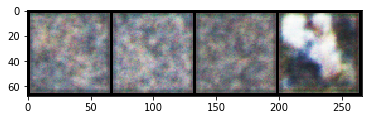

Starting epoch 11
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 0, 1, 0], device='cuda:0')
1 : bees
0 : ants


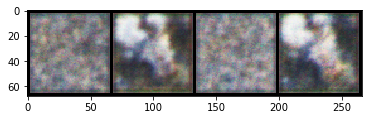

Starting epoch 12
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 0, 0, 0], device='cuda:0')
1 : bees
0 : ants


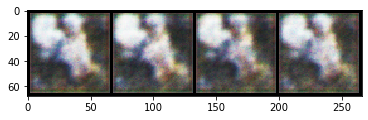

Starting epoch 13
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 0, 0, 1], device='cuda:0')
1 : bees
0 : ants


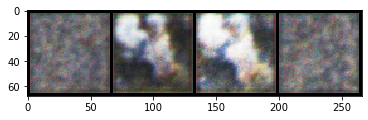

Starting epoch 14
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 0, 1, 1], device='cuda:0')
1 : bees
0 : ants


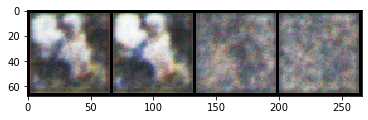

Starting epoch 15
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 0, 0, 0], device='cuda:0')
1 : bees
0 : ants


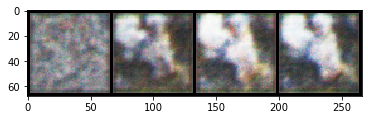

Starting epoch 16
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 1, 1, 0], device='cuda:0')
1 : bees
0 : ants


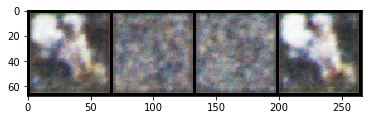

Starting epoch 17
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 0, 1, 0], device='cuda:0')
1 : bees
0 : ants


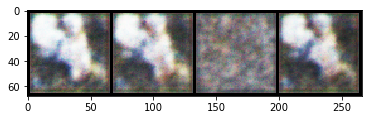

Starting epoch 18
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 0, 0, 1], device='cuda:0')
1 : bees
0 : ants


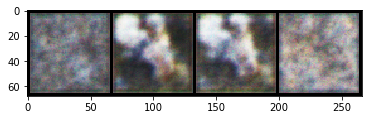

Starting epoch 19
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 0, 0, 1], device='cuda:0')
1 : bees
0 : ants


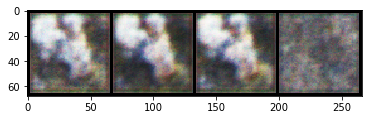

Starting epoch 20
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 0, 0, 1], device='cuda:0')
1 : bees
0 : ants


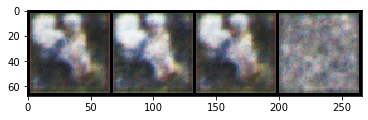

Starting epoch 21
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 1, 0, 0], device='cuda:0')
1 : bees
0 : ants


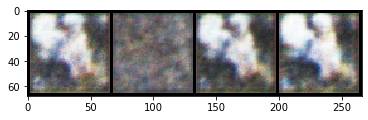

Starting epoch 22
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 0, 1, 0], device='cuda:0')
1 : bees
0 : ants


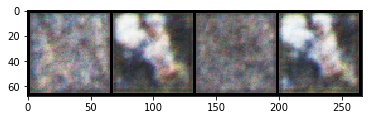

Starting epoch 23
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 0, 1, 0], device='cuda:0')
1 : bees
0 : ants


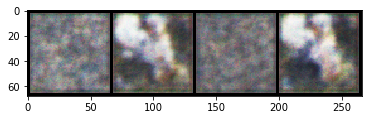

Starting epoch 24
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 0, 1, 1], device='cuda:0')
1 : bees
0 : ants


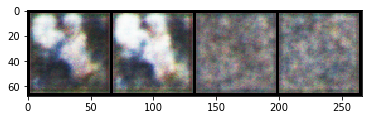

Starting epoch 25
g_loss: 0.0, d_loss: 13.815984725952148
tensor([0, 0, 1, 0], device='cuda:0')
1 : bees
0 : ants


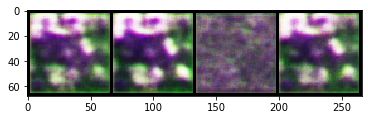

Starting epoch 26
g_loss: 0.0, d_loss: 0.0
tensor([0, 0, 0, 0], device='cuda:0')
1 : bees
0 : ants


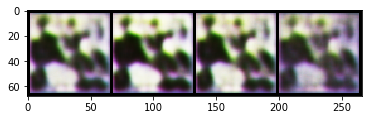

Starting epoch 27
g_loss: 0.0, d_loss: 27.63102149963379
tensor([1, 1, 0, 0], device='cuda:0')
1 : bees
0 : ants


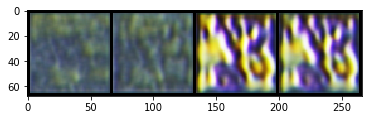

Starting epoch 28
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 0, 0, 0], device='cuda:0')
1 : bees
0 : ants


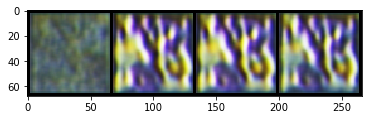

Starting epoch 29
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 1, 1, 0], device='cuda:0')
1 : bees
0 : ants


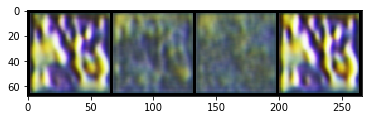

Starting epoch 30
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 1, 1, 0], device='cuda:0')
1 : bees
0 : ants


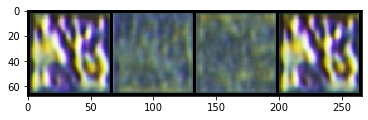

Starting epoch 31
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 1, 1, 1], device='cuda:0')
1 : bees
0 : ants


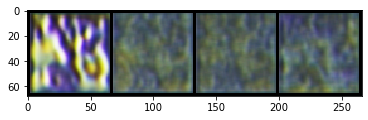

Starting epoch 32
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 0, 1, 1], device='cuda:0')
1 : bees
0 : ants


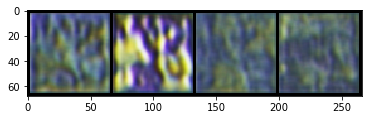

Starting epoch 33
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 0, 0, 1], device='cuda:0')
1 : bees
0 : ants


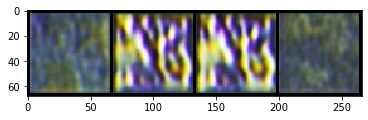

Starting epoch 34
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 0, 1, 0], device='cuda:0')
1 : bees
0 : ants


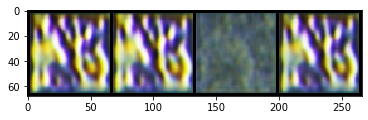

Starting epoch 35
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 0, 0, 0], device='cuda:0')
1 : bees
0 : ants


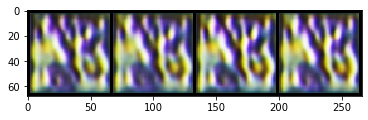

Starting epoch 36
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 1, 0, 1], device='cuda:0')
1 : bees
0 : ants


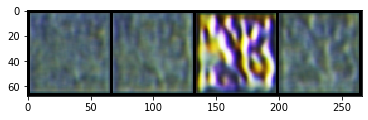

Starting epoch 37
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 1, 0, 0], device='cuda:0')
1 : bees
0 : ants


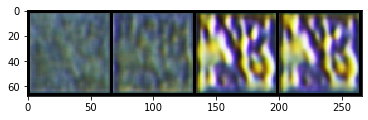

Starting epoch 38
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 1, 0, 0], device='cuda:0')
1 : bees
0 : ants


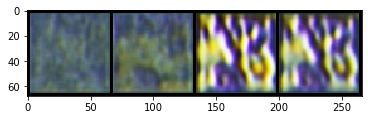

Starting epoch 39
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 0, 0, 1], device='cuda:0')
1 : bees
0 : ants


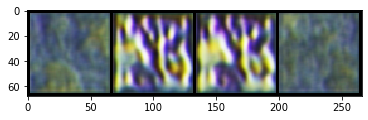

Starting epoch 40
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 0, 1, 0], device='cuda:0')
1 : bees
0 : ants


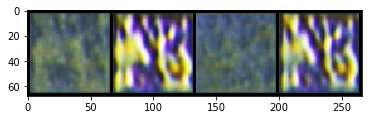

Starting epoch 41
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 0, 1, 1], device='cuda:0')
1 : bees
0 : ants


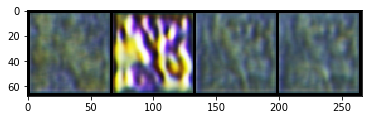

Starting epoch 42
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 1, 1, 0], device='cuda:0')
1 : bees
0 : ants


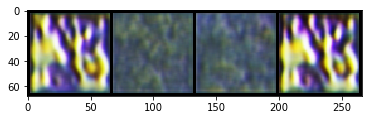

Starting epoch 43
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 1, 0, 1], device='cuda:0')
1 : bees
0 : ants


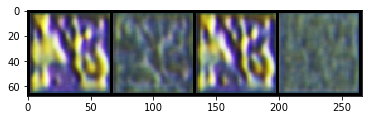

Starting epoch 44
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 1, 0, 1], device='cuda:0')
1 : bees
0 : ants


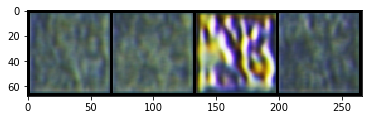

Starting epoch 45
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 1, 0, 1], device='cuda:0')
1 : bees
0 : ants


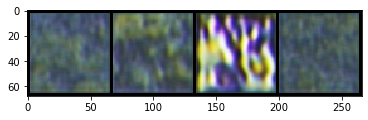

Starting epoch 46
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 0, 1, 0], device='cuda:0')
1 : bees
0 : ants


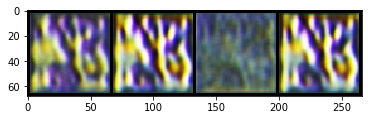

Starting epoch 47
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 1, 0, 1], device='cuda:0')
1 : bees
0 : ants


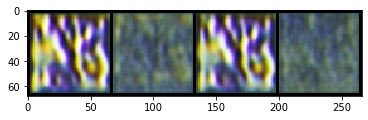

Starting epoch 48
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 1, 1, 0], device='cuda:0')
1 : bees
0 : ants


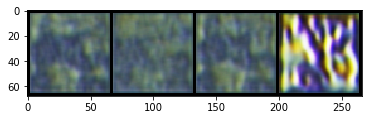

Starting epoch 49
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 0, 1, 1], device='cuda:0')
1 : bees
0 : ants


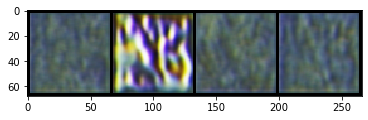

Starting epoch 50
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 1, 0, 1], device='cuda:0')
1 : bees
0 : ants


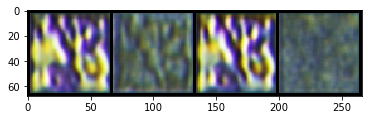

Starting epoch 51
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 0, 1, 0], device='cuda:0')
1 : bees
0 : ants


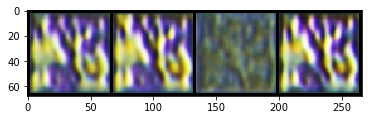

Starting epoch 52
g_loss: 27.63102149963379, d_loss: 0.0
tensor([1, 1, 1, 1], device='cuda:0')
1 : bees
0 : ants


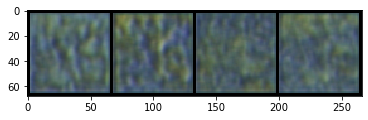

Starting epoch 53
g_loss: 27.63102149963379, d_loss: 0.0
tensor([0, 1, 0, 1], device='cuda:0')
1 : bees
0 : ants


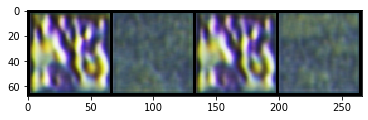

Starting epoch 54
g_loss: 27.63102149963379, d_loss: 6.907755374908447
tensor([1, 1, 0, 0], device='cuda:0')
1 : bees
0 : ants


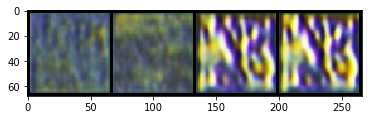

Starting epoch 55
g_loss: 0.0, d_loss: 13.815510749816895
tensor([0, 1, 0, 0], device='cuda:0')
1 : bees
0 : ants


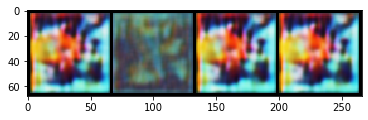

Starting epoch 56
g_loss: 0.0, d_loss: 0.0
tensor([1, 0, 1, 1], device='cuda:0')
1 : bees
0 : ants


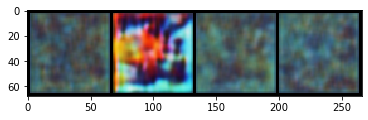

Starting epoch 57
g_loss: 0.0, d_loss: 6.907755374908447
tensor([1, 0, 1, 1], device='cuda:0')
1 : bees
0 : ants


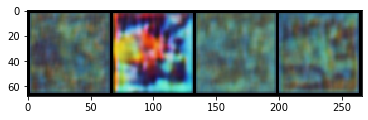

Starting epoch 58
g_loss: 0.0, d_loss: 13.815510749816895
tensor([1, 0, 0, 1], device='cuda:0')
1 : bees
0 : ants


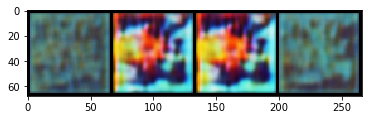

Starting epoch 59
g_loss: 0.0, d_loss: 27.63102149963379
tensor([1, 0, 0, 0], device='cuda:0')
1 : bees
0 : ants


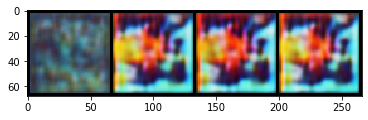

Starting epoch 60
g_loss: 0.0, d_loss: 13.815510749816895
tensor([0, 0, 1, 1], device='cuda:0')
1 : bees
0 : ants


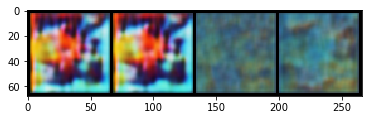

Starting epoch 61
g_loss: 0.0, d_loss: 13.815510749816895
tensor([0, 0, 1, 1], device='cuda:0')
1 : bees
0 : ants


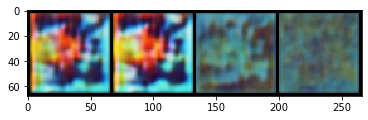

Starting epoch 62
g_loss: 0.0, d_loss: 13.815510749816895
tensor([0, 0, 1, 1], device='cuda:0')
1 : bees
0 : ants


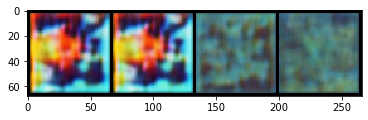

Starting epoch 63
g_loss: 0.0, d_loss: 13.815510749816895
tensor([1, 0, 1, 1], device='cuda:0')
1 : bees
0 : ants


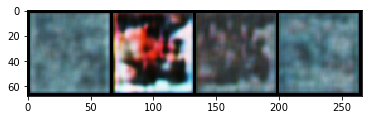

Starting epoch 64
g_loss: 0.0, d_loss: 20.7232666015625
tensor([0, 0, 0, 0], device='cuda:0')
1 : bees
0 : ants


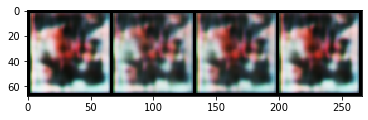

Starting epoch 65
g_loss: 0.0, d_loss: 27.63102149963379
tensor([1, 0, 0, 1], device='cuda:0')
1 : bees
0 : ants


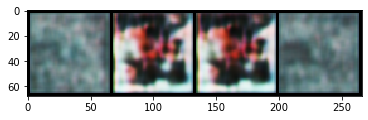

Starting epoch 66
g_loss: 0.0, d_loss: 13.815510749816895
tensor([0, 0, 1, 0], device='cuda:0')
1 : bees
0 : ants


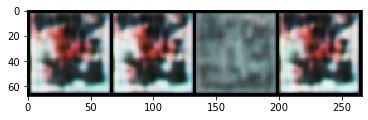

Starting epoch 67
g_loss: 0.0, d_loss: 20.7232666015625
tensor([0, 0, 0, 0], device='cuda:0')
1 : bees
0 : ants


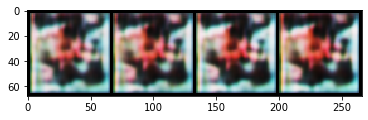

Starting epoch 68
g_loss: 0.0, d_loss: 13.815510749816895
tensor([1, 0, 1, 1], device='cuda:0')
1 : bees
0 : ants


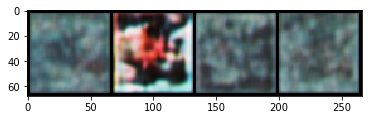

Starting epoch 69
g_loss: 0.0, d_loss: 13.815510749816895
tensor([1, 1, 0, 0], device='cuda:0')
1 : bees
0 : ants


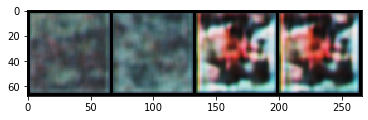

Starting epoch 70
g_loss: 0.0, d_loss: 13.815510749816895
tensor([0, 0, 1, 1], device='cuda:0')
1 : bees
0 : ants


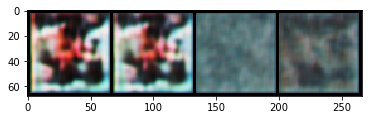

Starting epoch 71
g_loss: 0.0, d_loss: 6.907755374908447
tensor([0, 1, 0, 1], device='cuda:0')
1 : bees
0 : ants


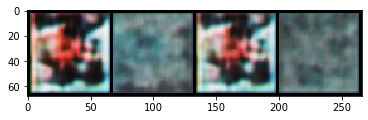

Starting epoch 72
g_loss: 0.0, d_loss: 13.815510749816895
tensor([0, 0, 1, 1], device='cuda:0')
1 : bees
0 : ants


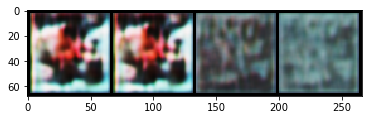

Starting epoch 73
g_loss: 0.0, d_loss: 13.815510749816895
tensor([0, 1, 1, 1], device='cuda:0')
1 : bees
0 : ants


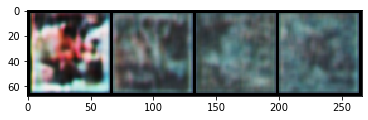

Starting epoch 74
g_loss: 0.0, d_loss: 13.815510749816895
tensor([1, 1, 0, 0], device='cuda:0')
1 : bees
0 : ants


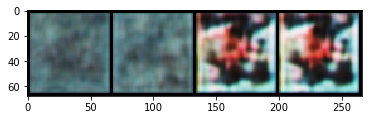

Starting epoch 75
g_loss: 0.0, d_loss: 20.7232666015625
tensor([0, 0, 0, 0], device='cuda:0')
1 : bees
0 : ants


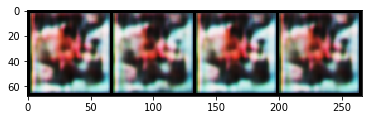

Starting epoch 76
g_loss: 0.0, d_loss: 13.815510749816895
tensor([0, 1, 1, 0], device='cuda:0')
1 : bees
0 : ants


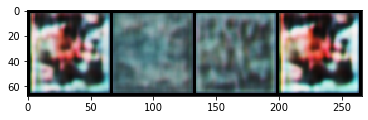

Starting epoch 77
g_loss: 0.0, d_loss: 27.63102149963379
tensor([1, 1, 0, 0], device='cuda:0')
1 : bees
0 : ants


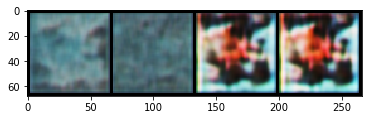

Starting epoch 78
g_loss: 0.0, d_loss: 20.7232666015625
tensor([1, 0, 0, 1], device='cuda:0')
1 : bees
0 : ants


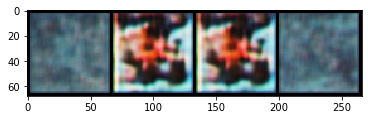

Starting epoch 79
g_loss: 0.0, d_loss: 6.907755374908447
tensor([1, 0, 1, 0], device='cuda:0')
1 : bees
0 : ants


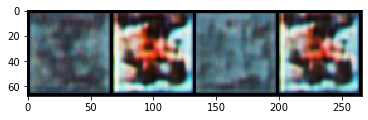

Starting epoch 80
g_loss: 0.0, d_loss: 20.7232666015625
tensor([1, 1, 1, 1], device='cuda:0')
1 : bees
0 : ants


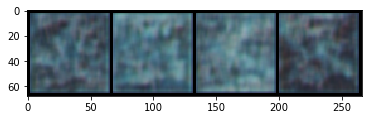

Starting epoch 81
g_loss: 0.0, d_loss: 13.815510749816895
tensor([0, 0, 1, 0], device='cuda:0')
1 : bees
0 : ants


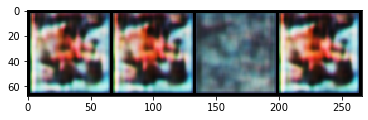

Starting epoch 82
g_loss: 0.0, d_loss: 13.815510749816895
tensor([0, 1, 0, 1], device='cuda:0')
1 : bees
0 : ants


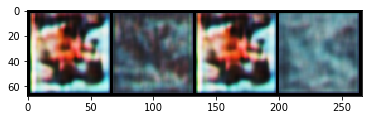

Starting epoch 83
g_loss: 0.0, d_loss: 6.907755374908447
tensor([0, 0, 0, 1], device='cuda:0')
1 : bees
0 : ants


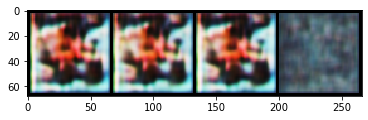

Starting epoch 84
g_loss: 0.0, d_loss: 13.815510749816895
tensor([1, 0, 1, 0], device='cuda:0')
1 : bees
0 : ants


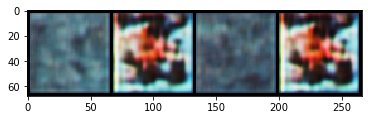

Starting epoch 85
g_loss: 0.0, d_loss: 20.7232666015625
tensor([0, 1, 1, 1], device='cuda:0')
1 : bees
0 : ants


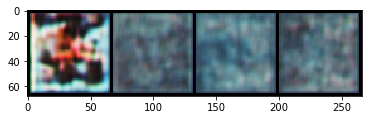

Starting epoch 86
g_loss: 0.0, d_loss: 13.815510749816895
tensor([1, 1, 0, 0], device='cuda:0')
1 : bees
0 : ants


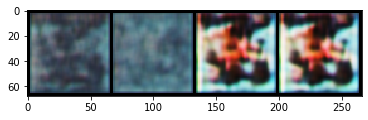

Starting epoch 87
g_loss: 0.0, d_loss: 20.7232666015625
tensor([1, 0, 0, 1], device='cuda:0')
1 : bees
0 : ants


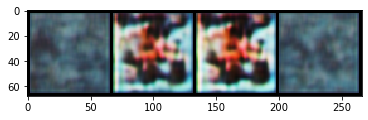

Starting epoch 88
g_loss: 0.0, d_loss: 6.907755374908447
tensor([1, 1, 1, 1], device='cuda:0')
1 : bees
0 : ants


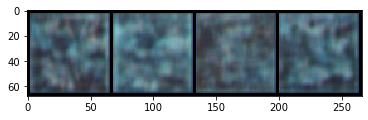

Starting epoch 89
g_loss: 0.0, d_loss: 6.907755374908447
tensor([0, 0, 1, 1], device='cuda:0')
1 : bees
0 : ants


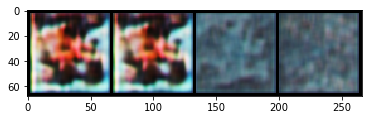

Starting epoch 90
g_loss: 0.0, d_loss: 0.0
tensor([0, 1, 0, 1], device='cuda:0')
1 : bees
0 : ants


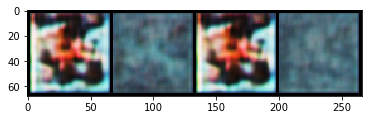

Starting epoch 91
g_loss: 0.0, d_loss: 27.63102149963379
tensor([1, 1, 0, 0], device='cuda:0')
1 : bees
0 : ants


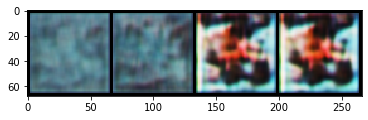

Starting epoch 92
g_loss: 0.0, d_loss: 13.815510749816895
tensor([0, 0, 0, 0], device='cuda:0')
1 : bees
0 : ants


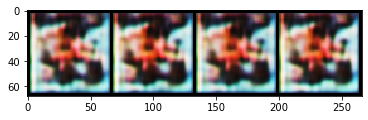

Starting epoch 93
g_loss: 0.0, d_loss: 20.7232666015625
tensor([1, 0, 1, 1], device='cuda:0')
1 : bees
0 : ants


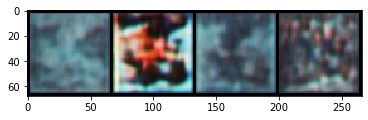

Starting epoch 94
g_loss: 0.0, d_loss: 13.815510749816895
tensor([0, 1, 0, 0], device='cuda:0')
1 : bees
0 : ants


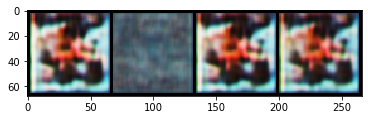

Starting epoch 95
g_loss: 0.0, d_loss: 13.815510749816895
tensor([1, 1, 0, 1], device='cuda:0')
1 : bees
0 : ants


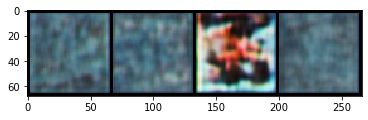

Starting epoch 96
g_loss: 0.0, d_loss: 13.815510749816895
tensor([0, 0, 1, 0], device='cuda:0')
1 : bees
0 : ants


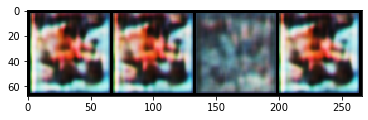

Starting epoch 97
g_loss: 0.0, d_loss: 6.907755374908447
tensor([0, 0, 0, 1], device='cuda:0')
1 : bees
0 : ants


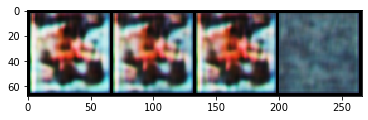

Starting epoch 98
g_loss: 0.0, d_loss: 20.7232666015625
tensor([0, 1, 0, 0], device='cuda:0')
1 : bees
0 : ants


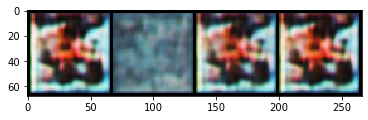

Starting epoch 99
g_loss: 0.0, d_loss: 20.7232666015625
tensor([0, 0, 1, 0], device='cuda:0')
1 : bees
0 : ants


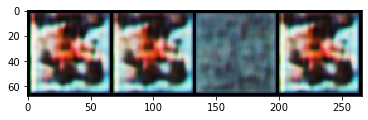

Starting epoch 100
g_loss: 0.0, d_loss: 13.815510749816895
tensor([0, 1, 0, 0], device='cuda:0')
1 : bees
0 : ants


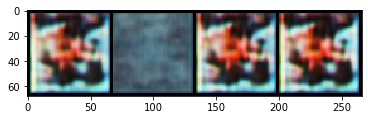

In [12]:
# train the network
epochs = 100
display_step = 300

from tqdm import tqdm

for i in range(epochs):
    print(f'Starting epoch {i+1}')
    for idx, (image, labels) in enumerate(dataloaders['train']):
            
        real_images = image.to('cuda')
        labels = labels.to('cuda')
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
        
    generator.eval()
    print(f'g_loss: {g_loss}, d_loss: {d_loss}')
    z = Variable(torch.randn(4, 20)).cuda()
    
    labels = Variable(torch.LongTensor(np.random.randint(0, 2, batch_size))).cuda()
    sample_images = generator(z, labels).data.cpu()
    
    print(labels)
    print('1 : bees')
    print('0 : ants')
    grid = make_grid(sample_images).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()
    

g) Does this model work well enough? What might be the reason for this? 

No the model does not work well enough. The reason may be because of the dataset. The bees and the ants don't really have a standardised picture format to identify themselves. Most prominently,the backgrounds seem to mostly overshadow the insects and as such there is little to be learnt about the image of hte insect itself.

Another reason why it may be not working well enough would be the model structure and the limitation of a non-pretrained model. To train the model, the dataset needs to be large and good enough for the model to learn the features of the ants and bees but currently we have a very small dataset to train the model and frankly not enough to train the model properly as seen by the generation results.